In [273]:
%cd ..

/Users/jason/repos/MoLab/models


/Users/jason/repos/MoLab/models/condmdi/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [274]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import torch
from utils.editing_util import get_keyframes_mask

In [275]:
cmap = "viridis"
# cmap = mpl.colors.ListedColormap(['whitesmoke', 'black'])

n_samples = 1
n_hml_features = 263
n_max_frames = 196

dummy_data = torch.ones((n_samples, n_hml_features, 1, n_max_frames))
dummy_lengths = torch.tensor([n_max_frames] * n_samples)

In [288]:
hml_sections = {
    "root_angular": (0, 1),
    "root_xz_vel": (1, 3),
    "root_y_pos": (3, 4),
}

last_idx = 4

# Local Joint Position w.r.t. Root
for i in range(1, 22):
    hml_sections[f"joint_pos_{i}"] = (last_idx, last_idx + 3)
    last_idx += 3

# Local Joint Quaternion Rotation w.r.t. Root
for i in range(1, 22):
    hml_sections[f"joint_rot_{i}"] = (last_idx, last_idx + 6)
    last_idx += 6

# Global Joint Velocity (including root)
for i in range(0, 22):
    hml_sections[f"joint_vel_{i}"] = (last_idx, last_idx + 3)
    last_idx += 3

hml_sections["contact"] = (last_idx, last_idx + 4)
last_idx += 4

assert last_idx == n_hml_features

In [314]:
hml_sections_broad = {
    "x_root": (0, 4),
    "joint_pos": (4, 67),
    "joint_rot": (67, 193),
    "joint_vel": (193, 259),
    "contact": (259, 263),
}
hml_sections_broad_tex = {
    r"$\mathbf{x}^{global}$": (0, 4),
    r"$\mathbf{j}^p$": (4, 67),
    r"$\mathbf{j}^r$": (67, 193),
    r"$\mathbf{j}^v$": (193, 259),
    r"$\mathbf{c}^f$": (259, 263),
}

In [378]:
def plot_masks(name, feat_mask, joint_mask=None, sections=None, save=False):
    plt.figure(figsize=(12, 8))
    plt.suptitle(name)

    plt.subplot(2, 1, 1)
    sns.heatmap(feat_mask[0, :, 0, :].numpy(), cmap=cmap, cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Features")

    if sections:
        yticks = []
        yticklabels = []

        for section_name, (start, end) in hml_sections_broad_tex.items():
            plt.axhline(start, color="red", linestyle="--", linewidth=0.5)
            plt.axhline(end, color="red", linestyle="--", linewidth=0.5)
            yticks.append((start + end) / 2)
            yticklabels.append(section_name)

        plt.yticks(yticks, yticklabels)

    plt.subplot(2, 1, 2)
    if joint_mask is not None:
        sns.heatmap(joint_mask[0, :, 0, :].numpy(), cmap=cmap, cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Joints")
    plt.tight_layout()
    if save:
        plt.savefig(f"condmdi/molab_condmdi/notebooks/figures/keyframes_mask_{name}.png")
    plt.show()

In [400]:
def plot_masks_separate(name, feat_mask, joint_mask=None, sections=None, save=False):
    plt.figure(figsize=(12, 4))
    plt.title(name)

    sns.heatmap(feat_mask[0, :, 0, :].numpy(), cmap=cmap, cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Features")

    if sections:
        yticks = []
        yticklabels = []
        for section_name, (start, end) in hml_sections_broad_tex.items():
            plt.axhline(start, color="red", linestyle="--", linewidth=0.5)
            plt.axhline(end, color="red", linestyle="--", linewidth=0.5)
            yticks.append((start + end) / 2)
            yticklabels.append(section_name)
        plt.yticks(yticks, yticklabels)

    plt.tight_layout()
    if save:
        plt.savefig(f"condmdi/molab_condmdi/notebooks/figures/feat_mask_{name}.png")
    plt.show()


    plt.figure(figsize=(12, 4))
    plt.title(name)
    if joint_mask is not None:
        sns.heatmap(joint_mask[0, :, 0, :].numpy(), cmap=cmap, cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Joints")
    plt.tight_layout()
    if save:
        plt.savefig(f"condmdi/molab_condmdi/notebooks/figures/joint_mask_{name}.png")
    plt.show()

In [401]:
def plot_mask_sections(name, feat_mask, sections=hml_sections):
    plt.figure(figsize=(13, 15))
    plt.title(name)
    sns.heatmap(feat_mask[0, :, 0, :].numpy(), cmap=cmap, cbar=False, linewidths=0.1, linecolor="black")

    yticks = []
    yticklabels = []

    for section_name, (start, end) in sections.items():
        plt.axhline(start, color="red", linestyle="--", linewidth=0.5)
        plt.axhline(end, color="red", linestyle="--", linewidth=0.5)
        yticks.append((start + end) / 2)
        yticklabels.append(section_name)
        # plt.text(-2, (start + end) / 2, section_name, color="red", horizontalalignment="right", verticalalignment="center")

    plt.yticks(yticks, yticklabels)

    plt.xlabel("Frames")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

Available `edit_mode`s:

- **benchmark_sparse** - keyframes are observed every `trans_length` frames, starting from the initial frame.

- **benchmark_clip** - the middle trans_length frames are generate, and the rest of the frames are observed keyframes.

- **lower_body** - lower body joints taken from input motion, upper body is generated.

- **pelvis** - pelvis trajectory is observed, rest of joints are generated.

- **right_wrist** - right wrist trajectory is observed, rest of joints are generated.

- **gmd_keyframes** - 5 keyframe observed randomly.

- **uncond** - no keyframes for unconditioned sampling.

- **pelvis_vr** - pelvis and VR joints trajectory are observed, rest of joints are generated.

- **pelvis_feet** - pelvis and feet trajectory are observed, rest of joints are generated.

- **random_frames** - randomly select the number of keyframes and their placement; intended for training.

- **random_joints** - joints and keyframes are sampled randomly; intended for training.

- **random** - features, joints, and keyframes are sampled randomly; intended for training.

## `random_frames`

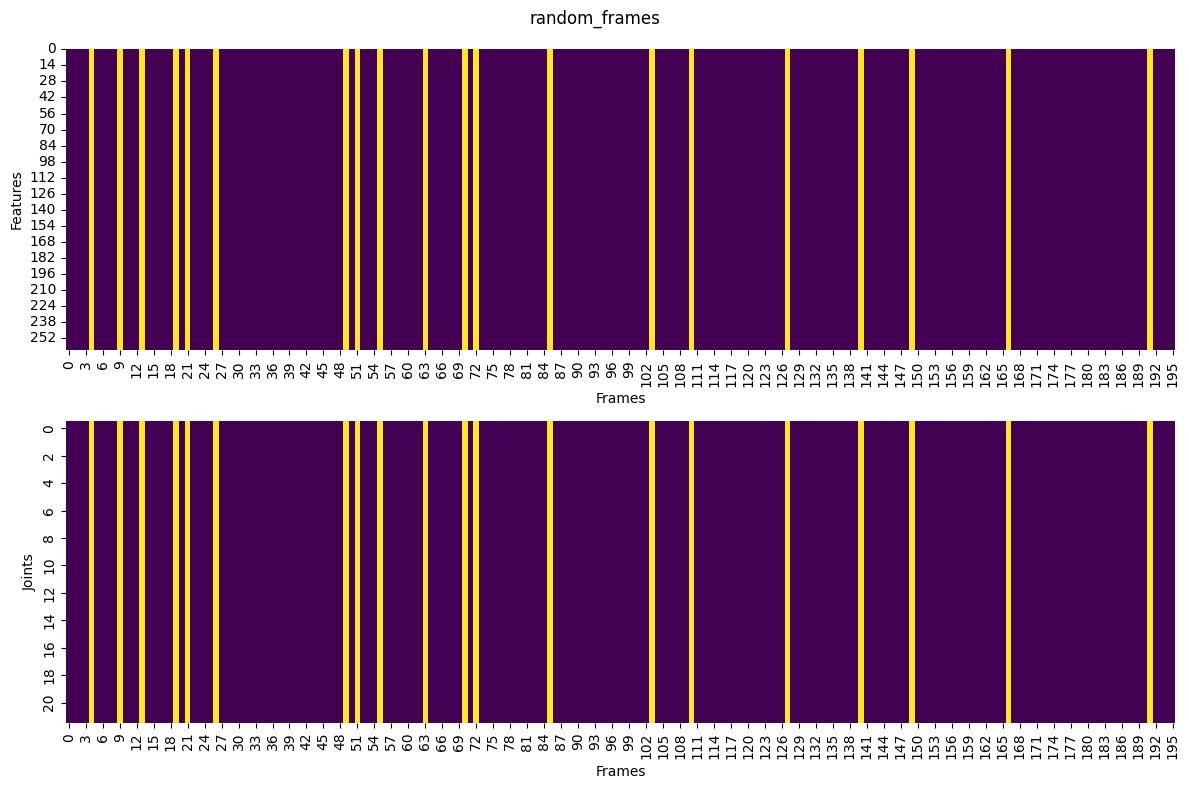

In [402]:
mode = "random_frames"

feat_mask, joint_mask = get_keyframes_mask(
    data=dummy_data,
    lengths=dummy_lengths,
    edit_mode=mode,
    get_joint_mask=True,
)

plot_masks(mode, feat_mask, joint_mask)

## `random_joints`

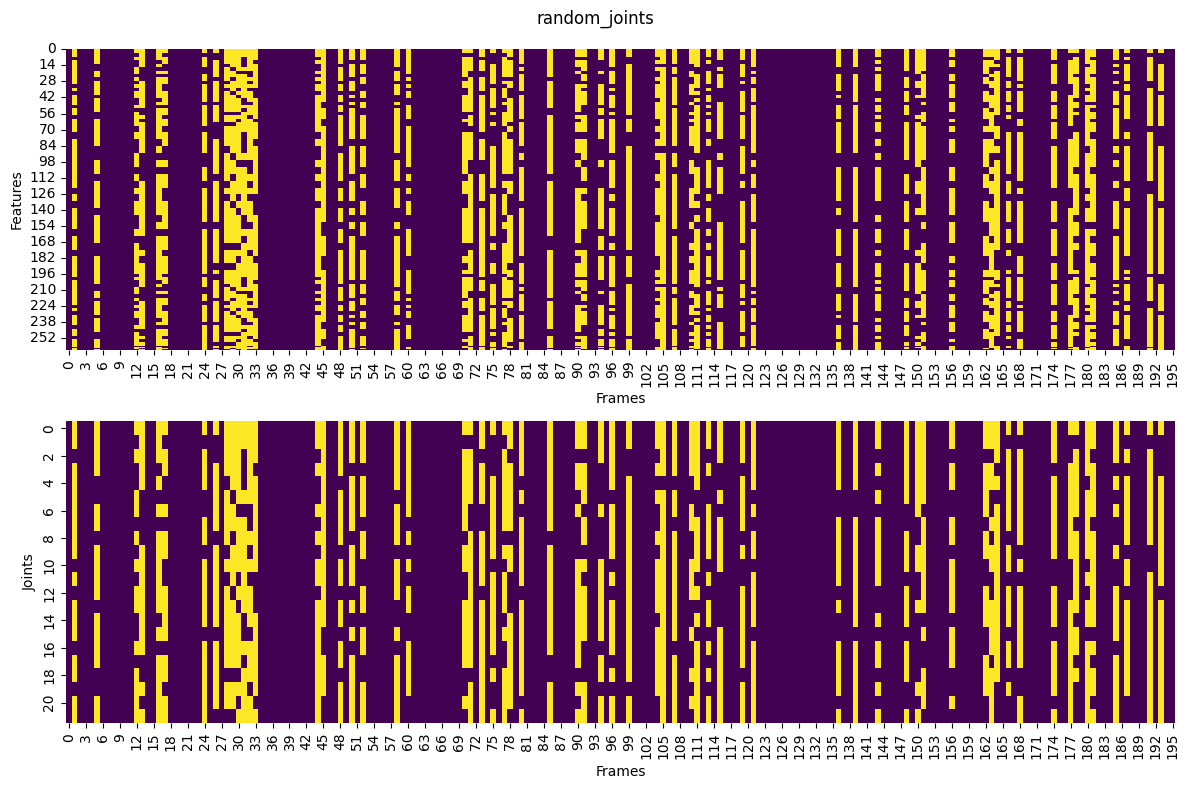

In [403]:
mode = "random_joints"

feat_mask, joint_mask = get_keyframes_mask(
    data=dummy_data,
    lengths=dummy_lengths,
    edit_mode=mode,
    get_joint_mask=True,
)

plot_masks(mode, feat_mask, joint_mask)

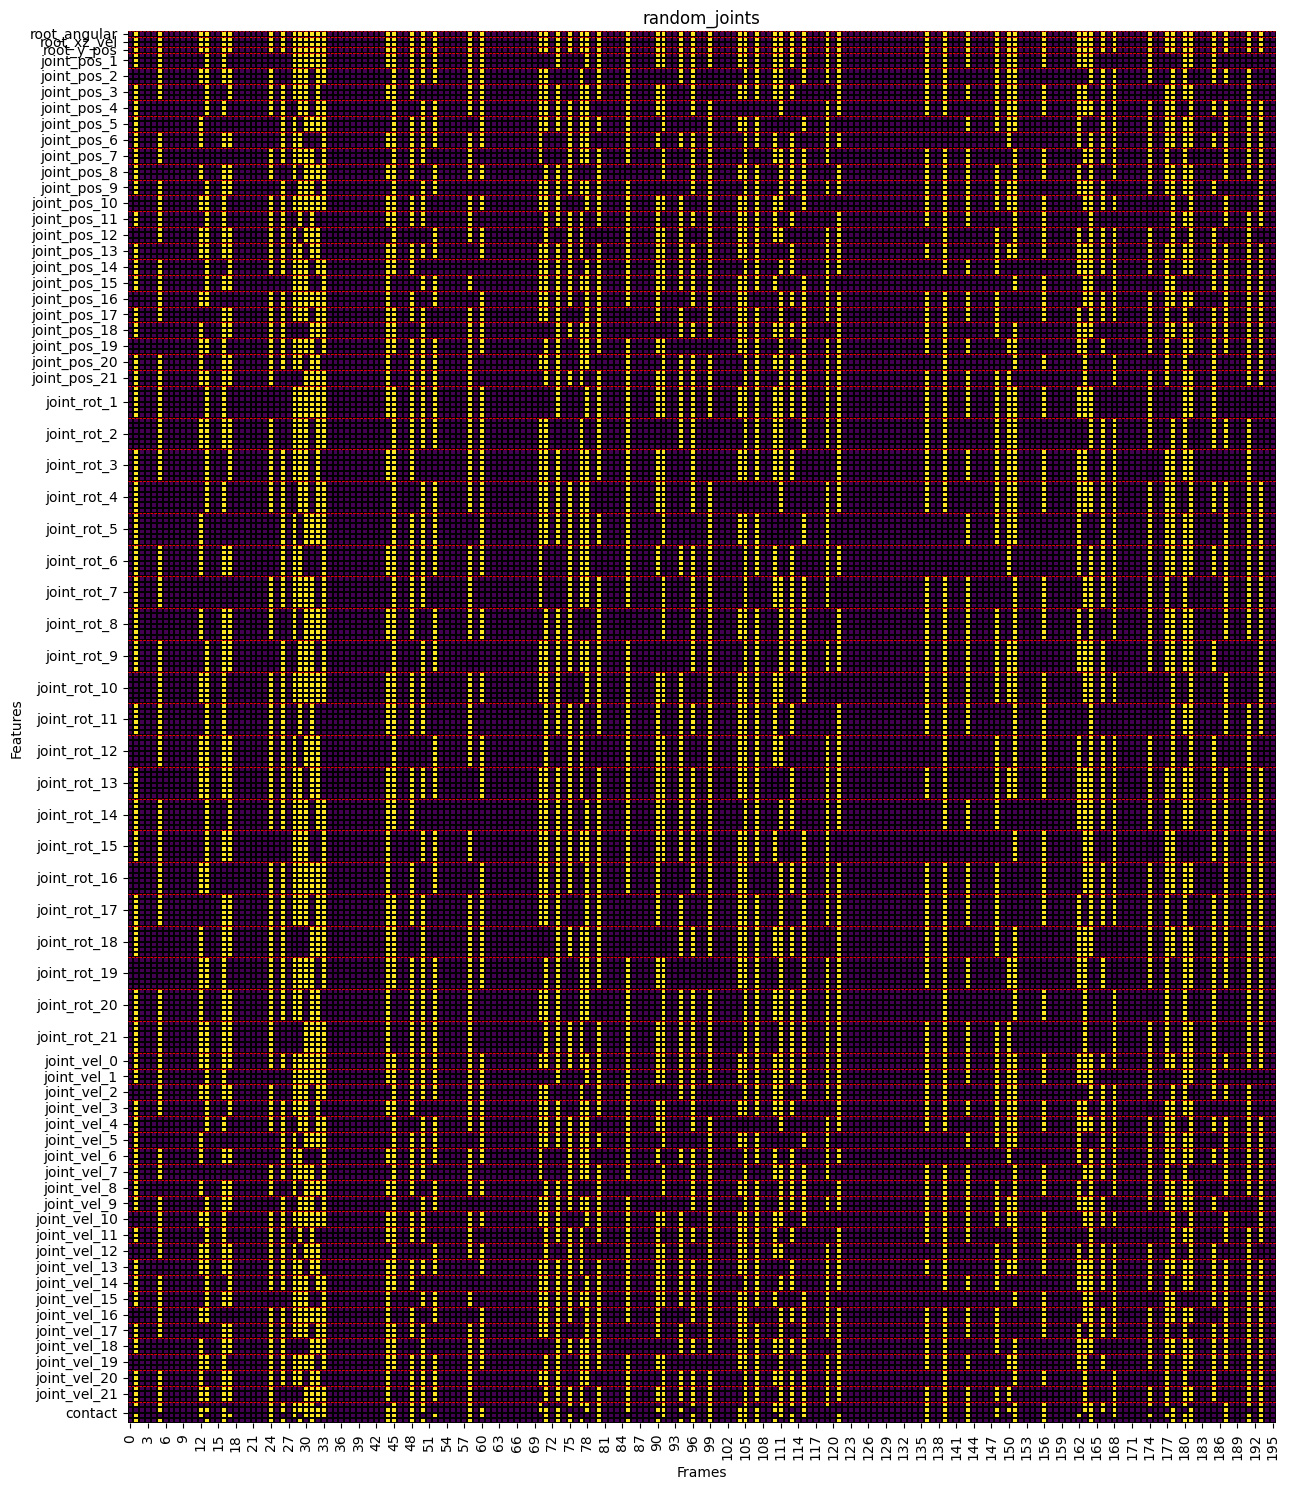

In [404]:
plot_mask_sections(mode, feat_mask)

## `random`

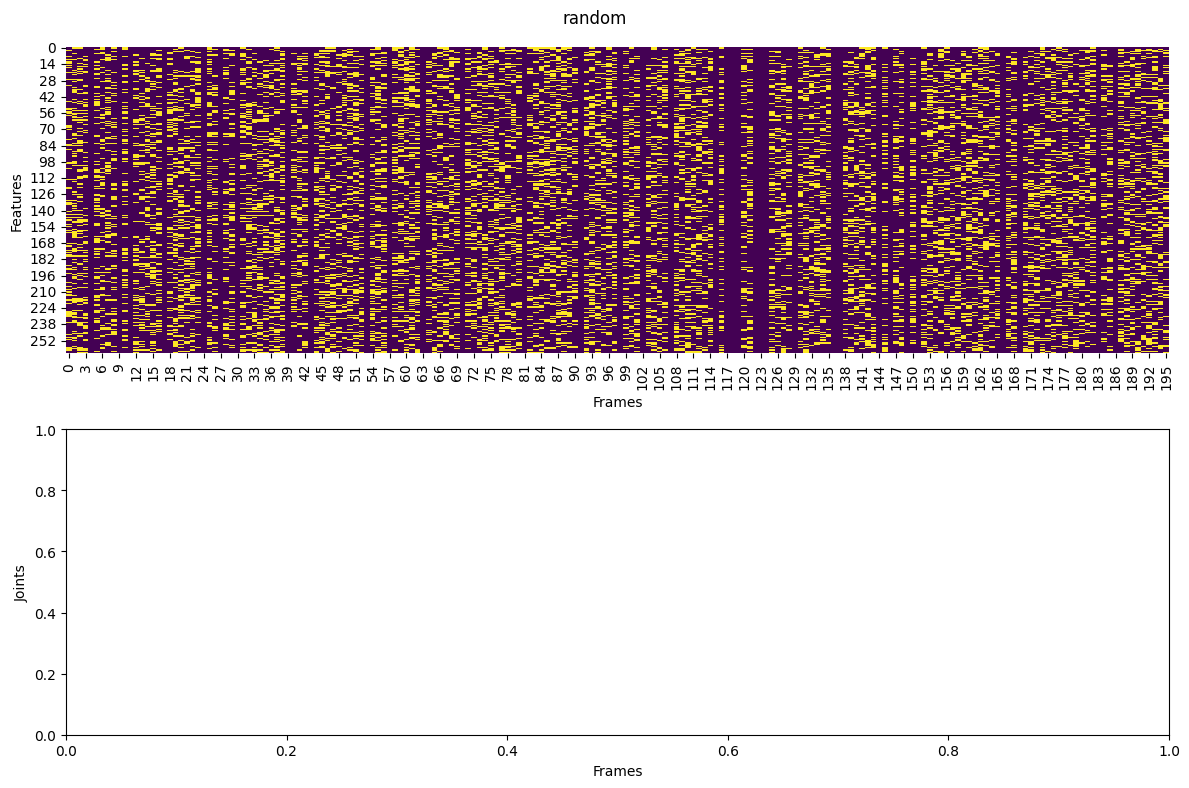

In [405]:
mode = "random"

feat_mask = get_keyframes_mask(
    data=dummy_data,
    lengths=dummy_lengths,
    edit_mode=mode,
    get_joint_mask=False,
)

plot_masks(mode, feat_mask)

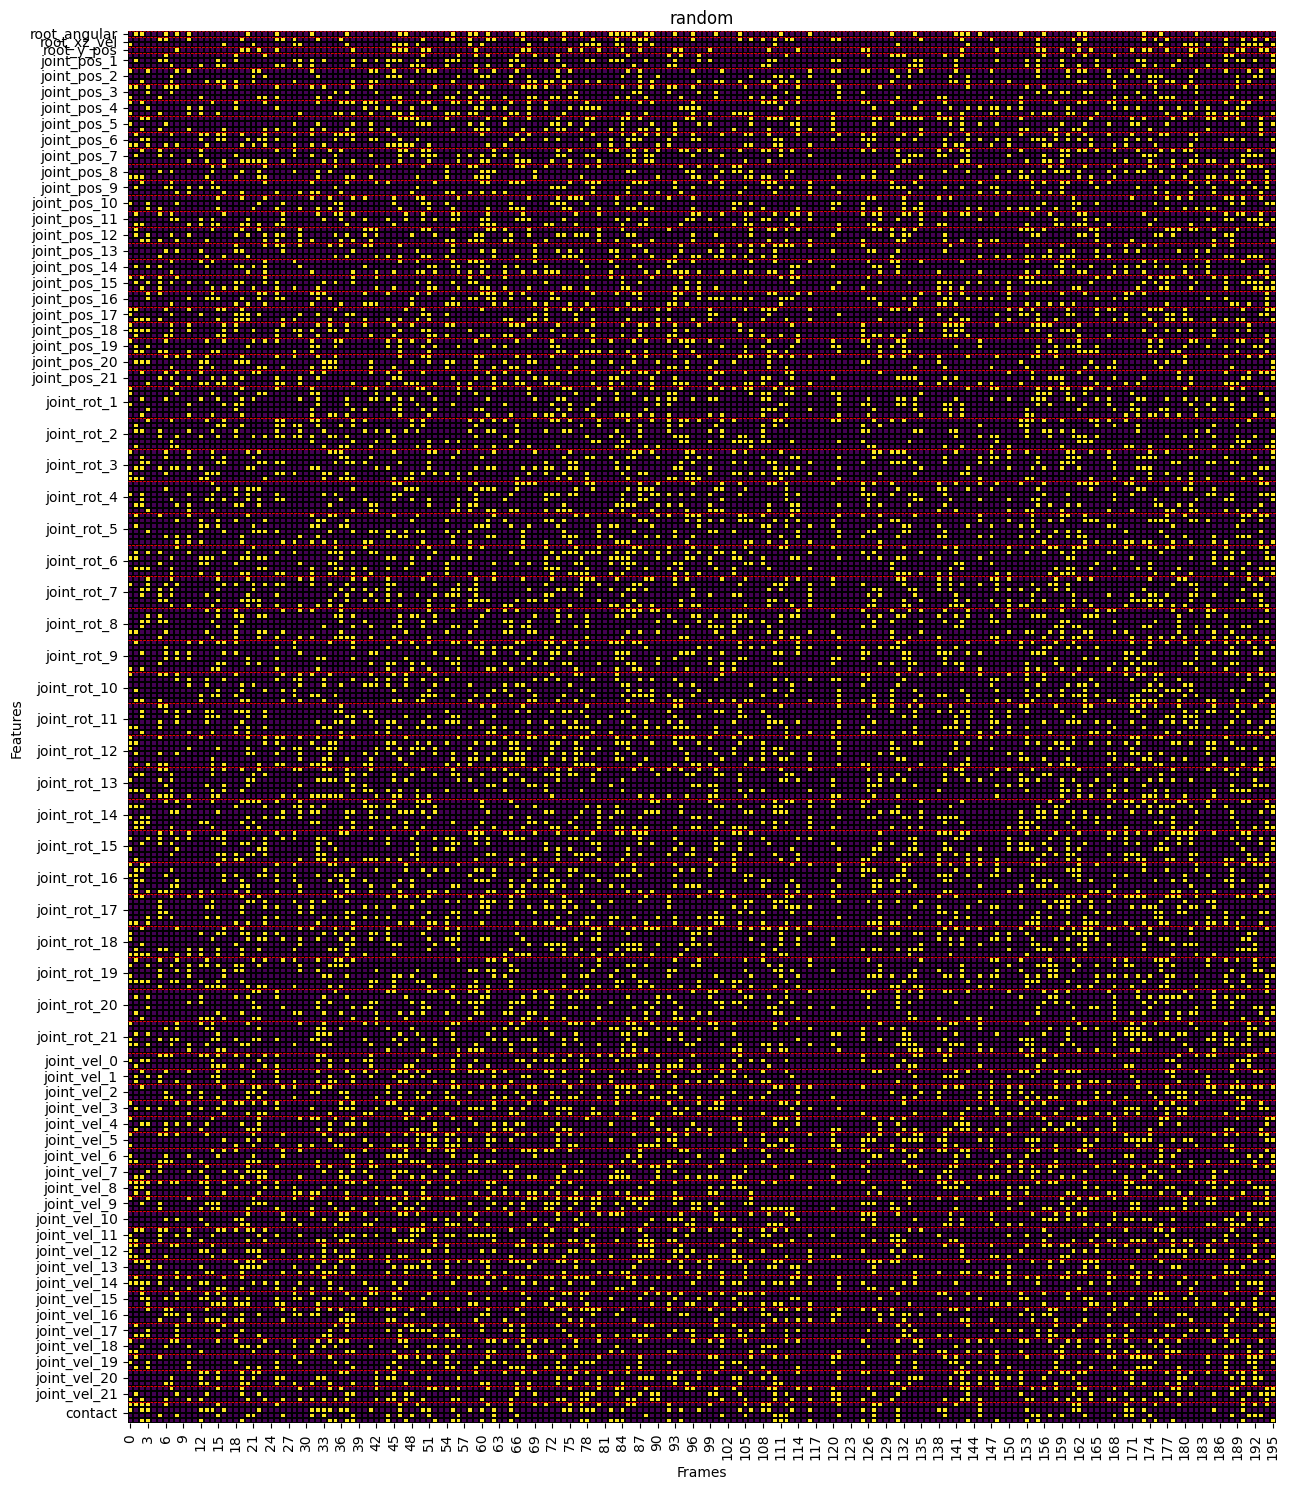

In [406]:
plot_mask_sections(mode, feat_mask)

---

## Overview of all edit modes

In [407]:
modes = [
    "benchmark_sparse",
    "benchmark_clip",
    "uncond",
    "right_wrist",
    "lower_body",
    "pelvis_feet",
    "pelvis_vr",
    "pelvis",
    "gmd_keyframes",
    "random_frames",
    "random_joints",
    "random",
]

mode_to_masks = {}

for mode in modes:
    out = get_keyframes_mask(
        data=dummy_data,
        lengths=dummy_lengths,
        edit_mode=mode,
        get_joint_mask=mode!="random",
    )

    if mode == "random":
        feat_mask = out
        mode_to_masks[mode] = (feat_mask, None)
    else:
        feat_mask, joint_mask = out
        mode_to_masks[mode] = (feat_mask, joint_mask)


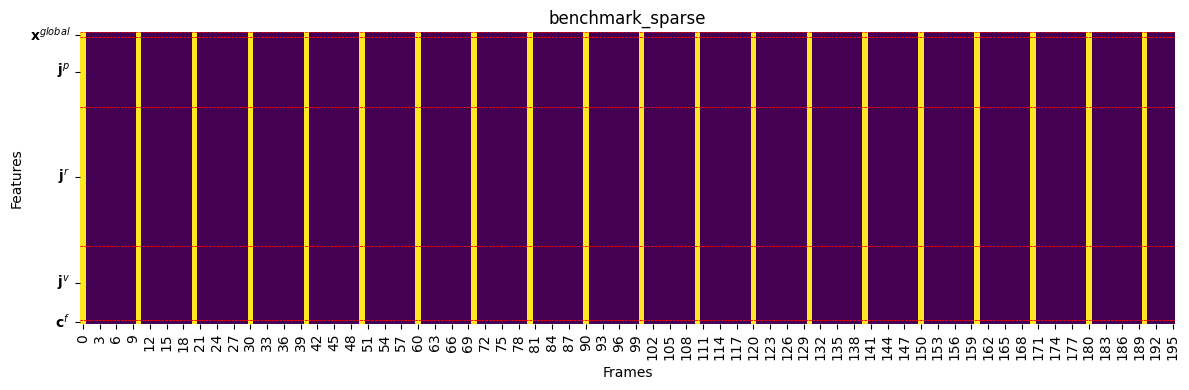

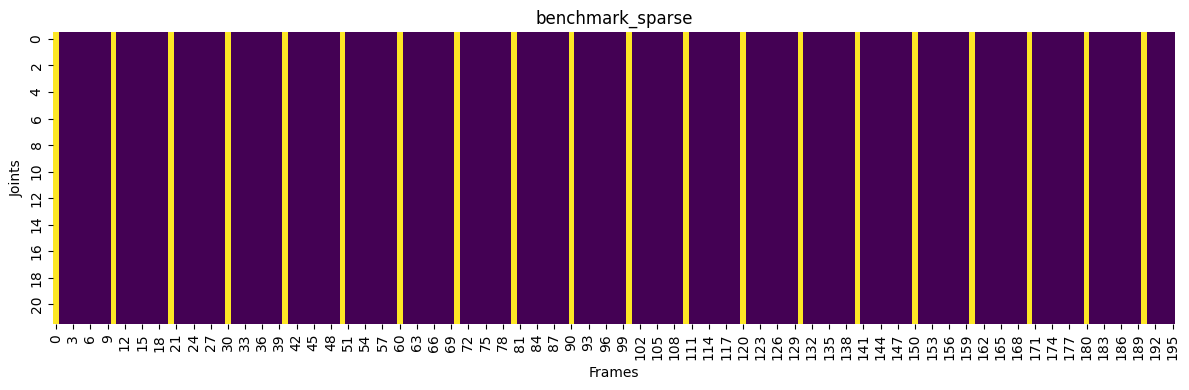

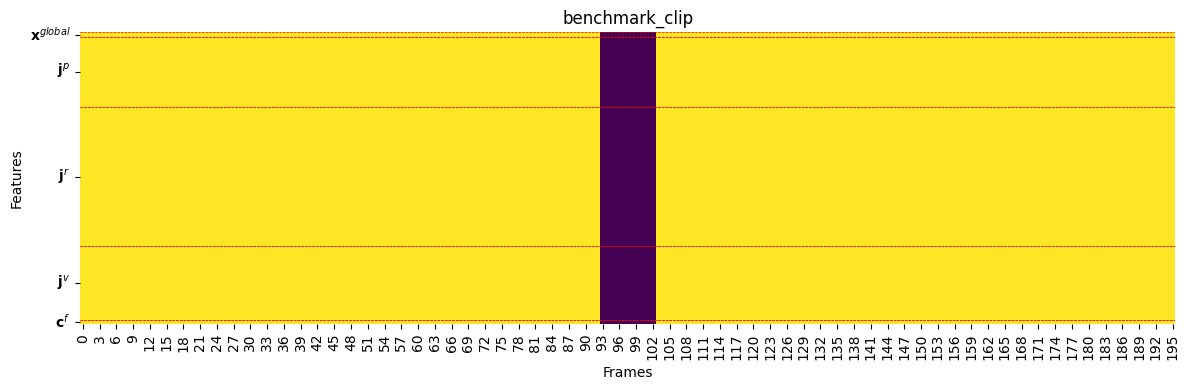

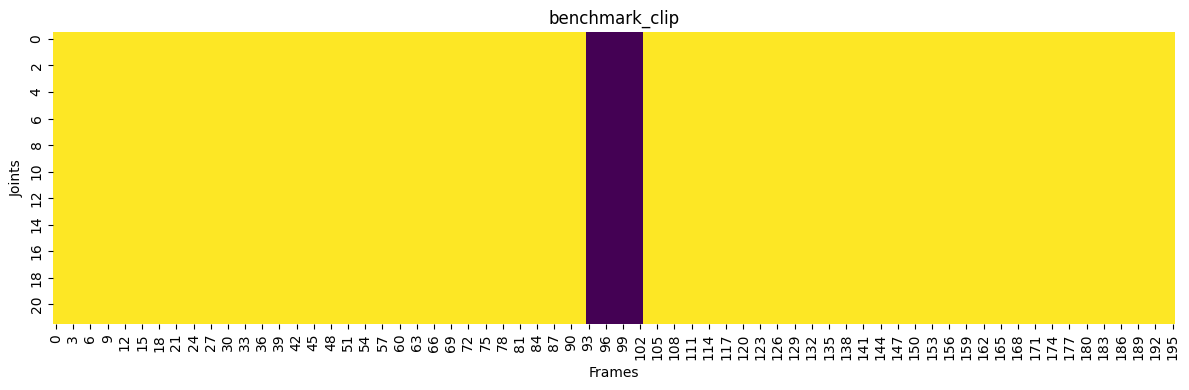

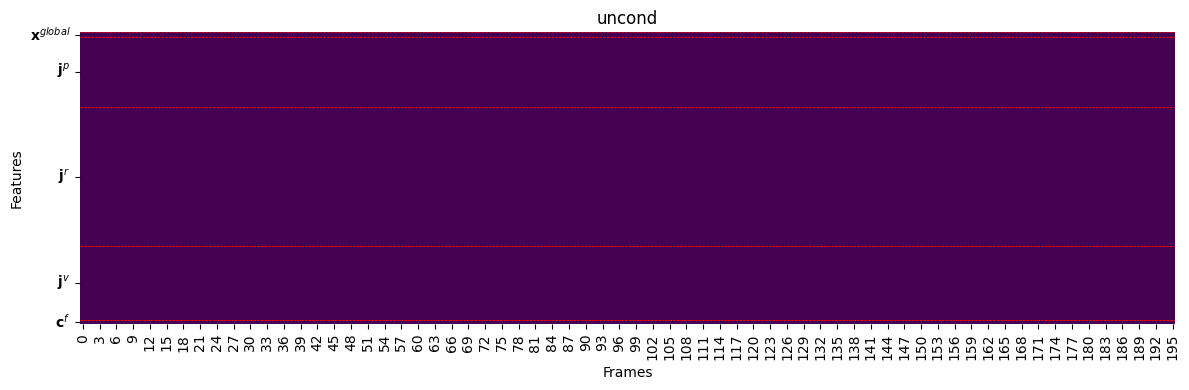

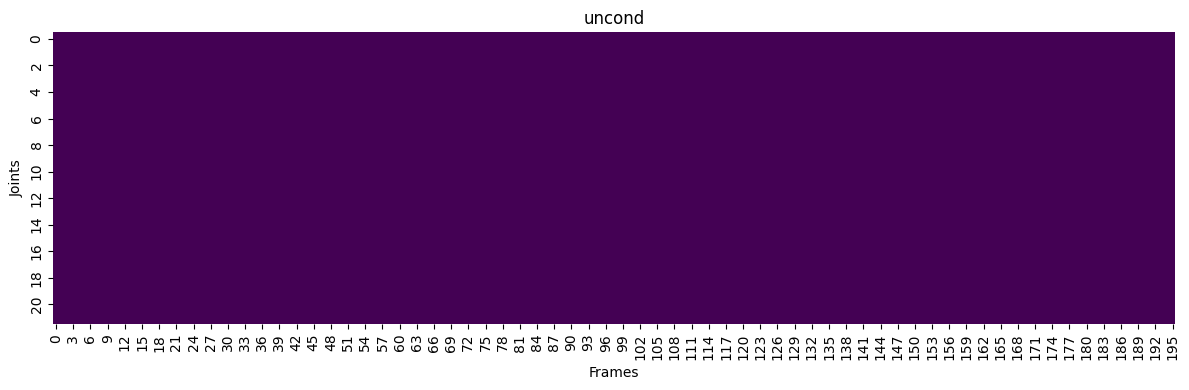

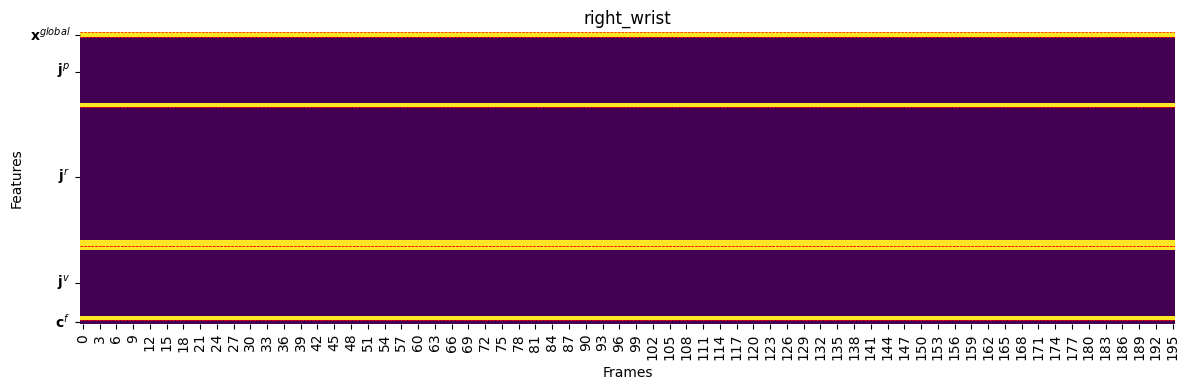

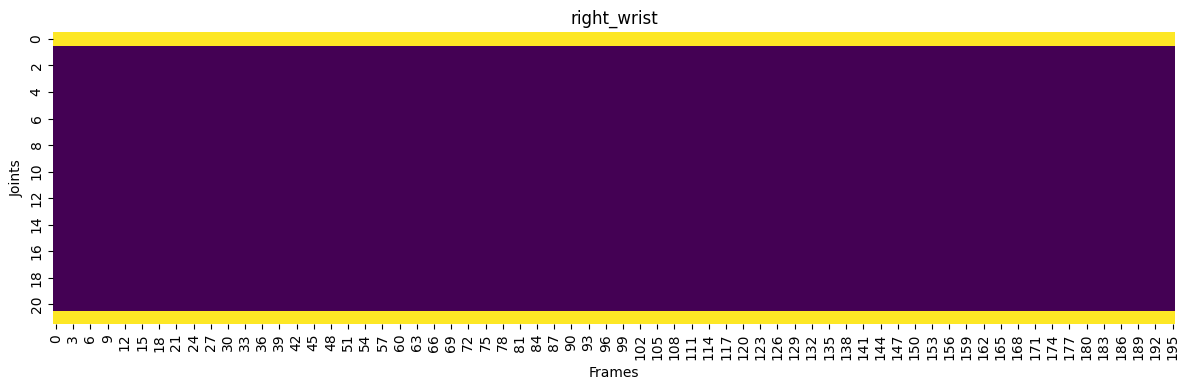

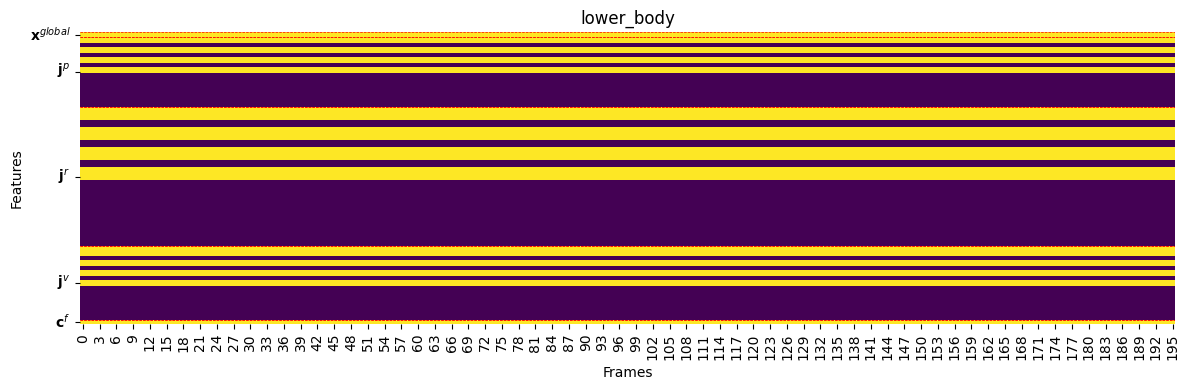

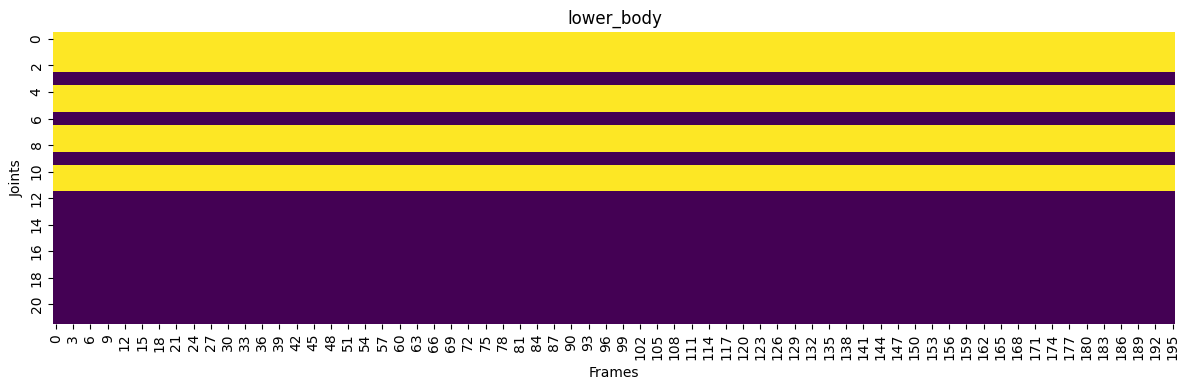

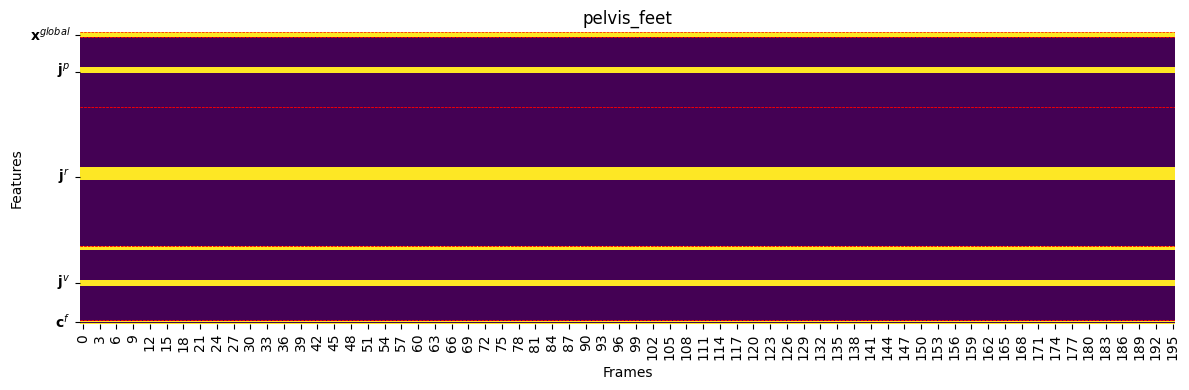

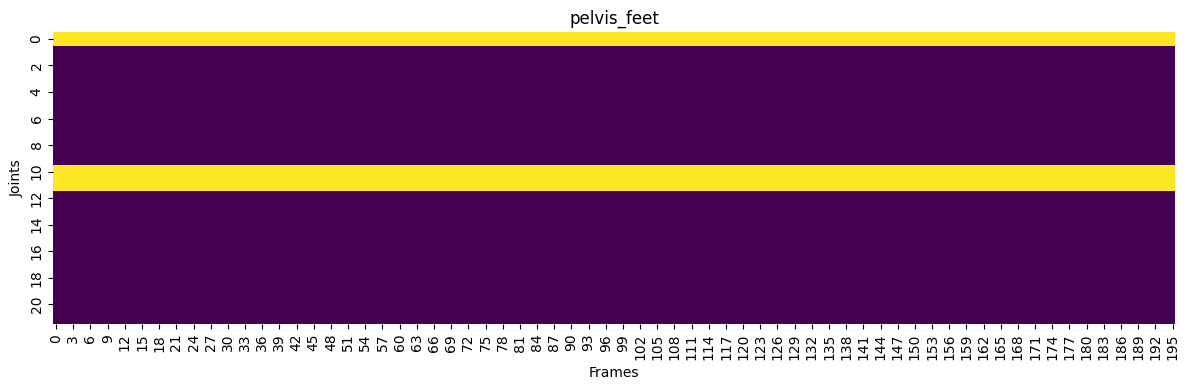

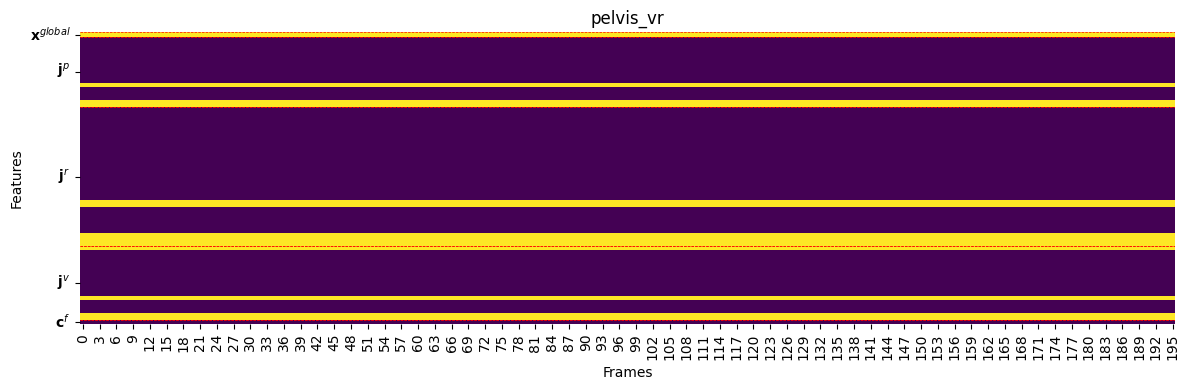

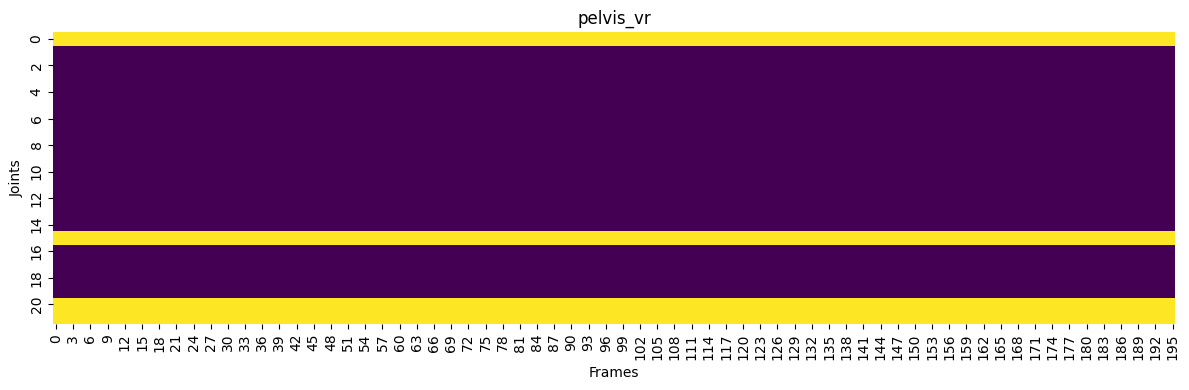

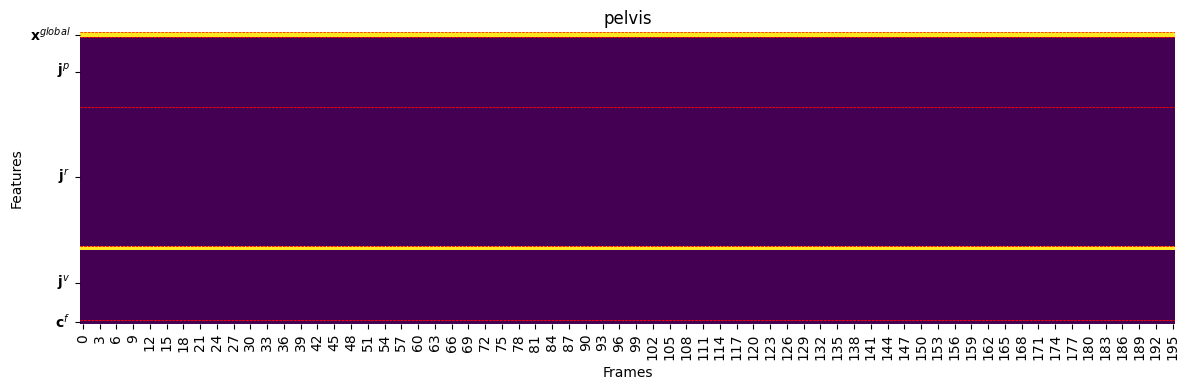

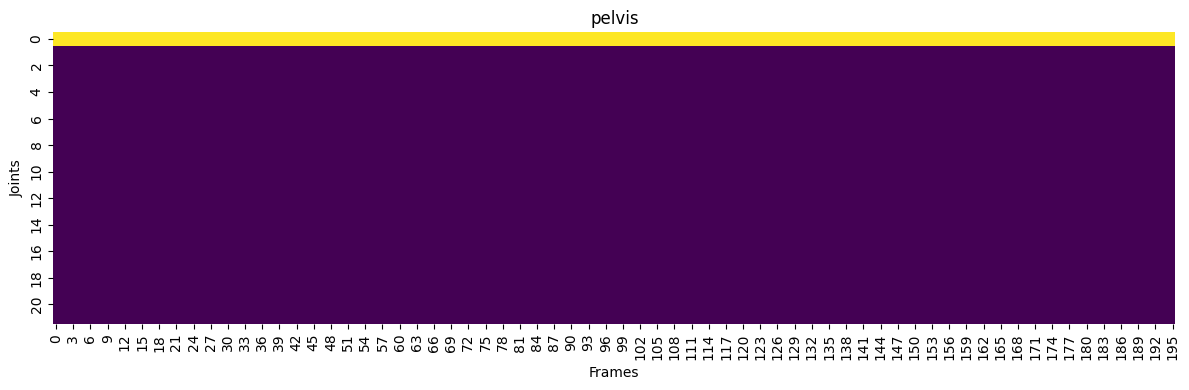

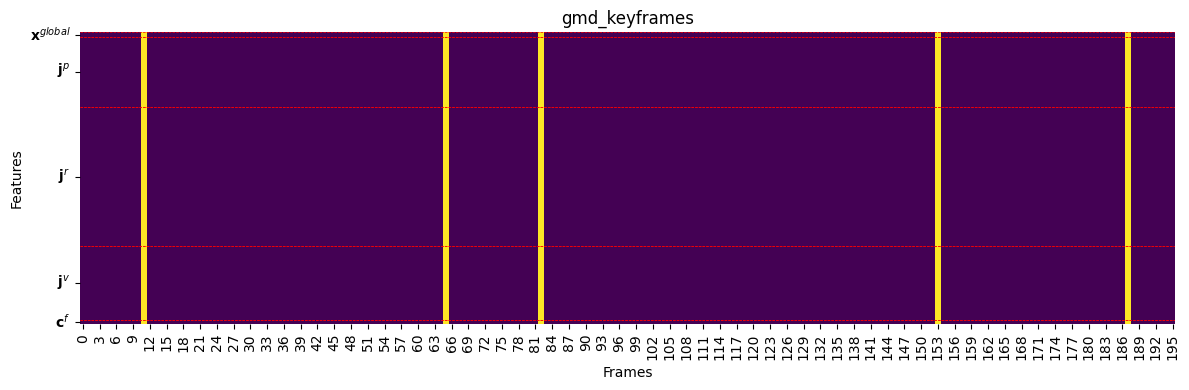

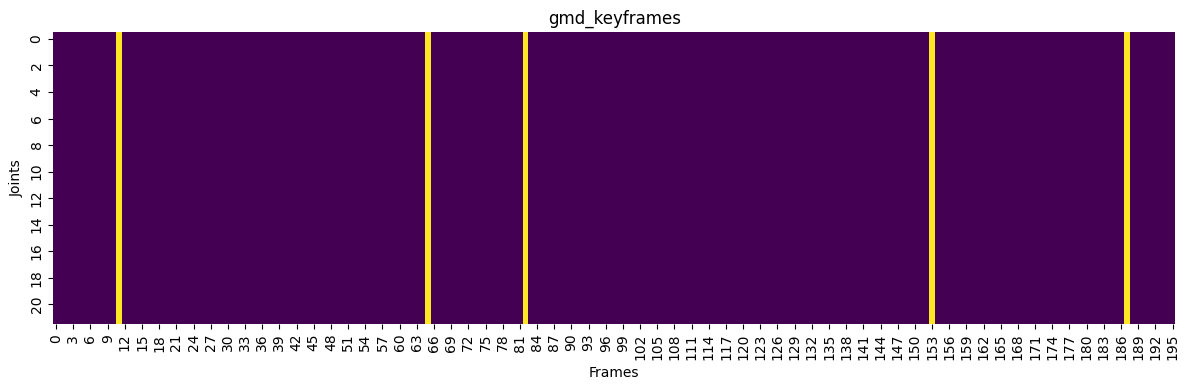

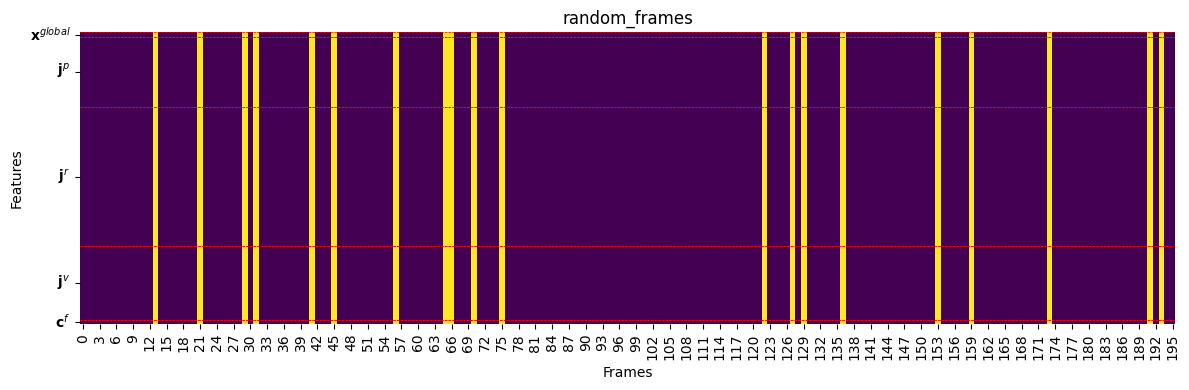

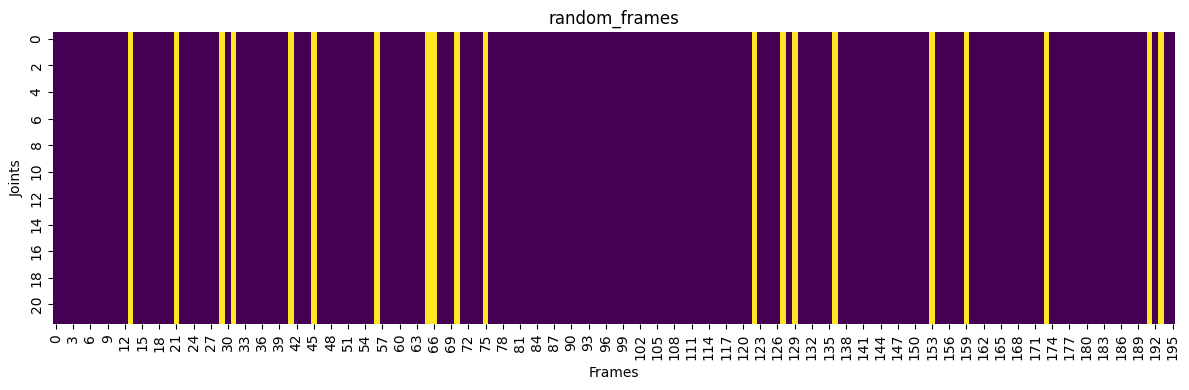

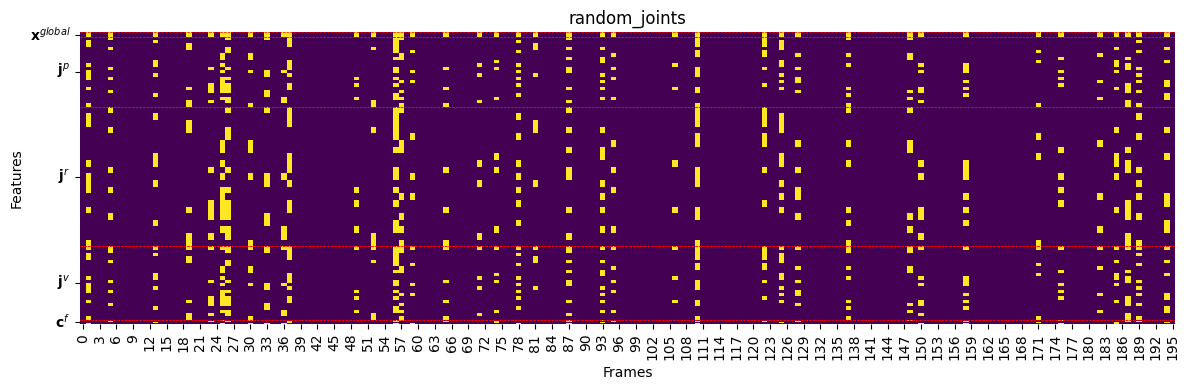

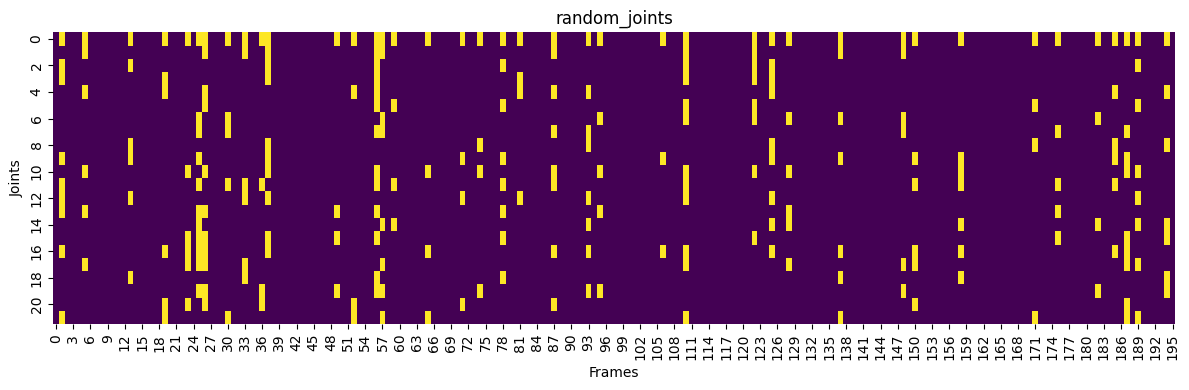

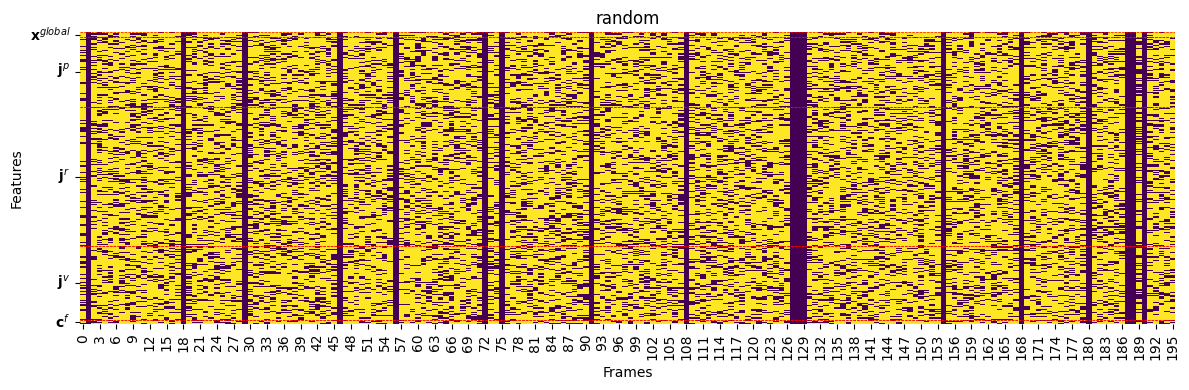

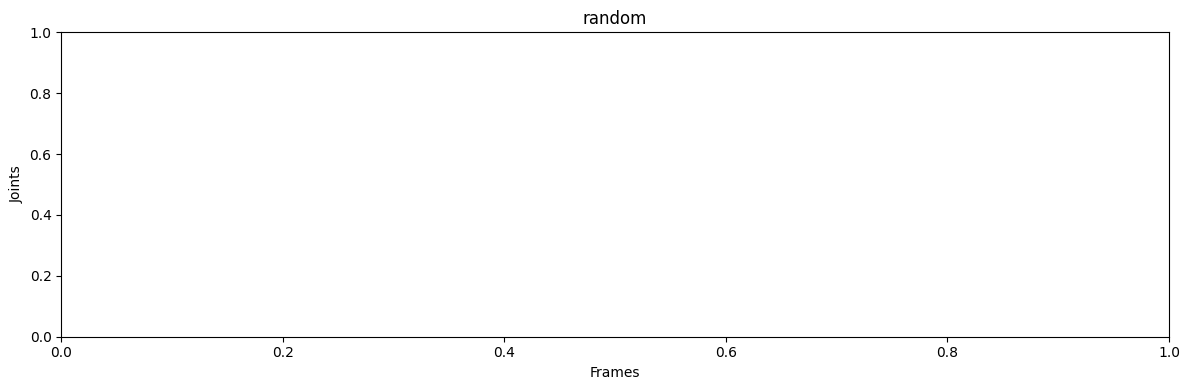

In [408]:
for mode, masks in mode_to_masks.items():
    # plot_masks(mode, masks[0], masks[1], hml_sections_broad_tex, save=True)
    plot_masks_separate(mode, masks[0], masks[1], hml_sections_broad_tex, save=True)


---

## `random_frames` without velocities

**NOTE**: this still contains root xz velocity and root rotational velocity

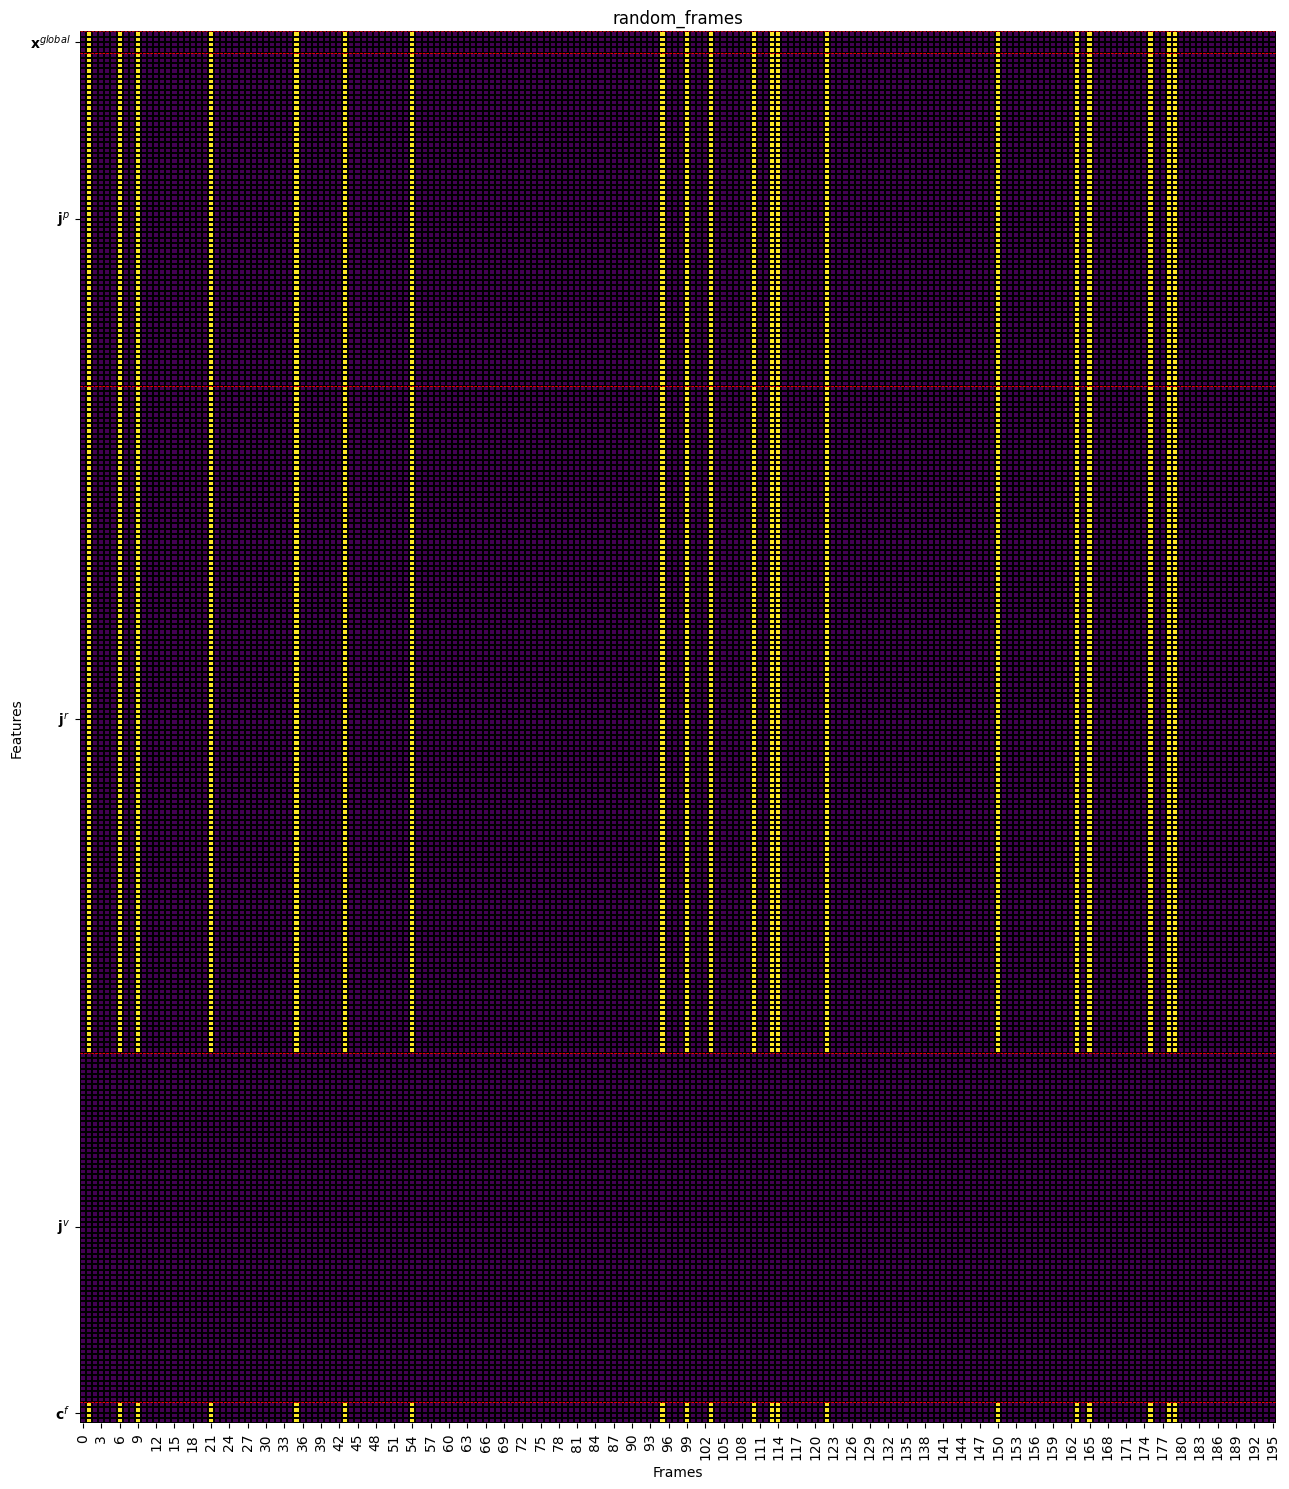

In [409]:
mode = "random_frames"

feat_mask, joint_mask = get_keyframes_mask(
    data=dummy_data,
    lengths=dummy_lengths,
    edit_mode=mode,
    feature_mode="pos_rot",
    get_joint_mask=True,
)

# plot_masks(mode, feat_mask, joint_mask)
# plot_mask_sections(mode, feat_mask, hml_sections)
plot_mask_sections(mode, feat_mask, hml_sections_broad_tex)